Check the version of python and packages:

In [1]:
!python --version

Python 3.7.3


In [81]:
!pip install scikit-multilearn

     |████████████████████████████████| 89 kB 941 kB/s eta 0:00:01


In [116]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestClassifier
from skmultilearn.problem_transform import ClassifierChain
from sklearn.metrics import make_scorer

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

import warnings
warnings.filterwarnings('ignore')

%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [20]:
from model import DenseNet, Model
from evaluate import accuracy_score, precision_score, recall_score, f1_score

In [4]:
SEED = 123
np.random.seed(SEED)
torch.manual_seed(SEED)

In [5]:
data_dir = './DATA/lish-moa/'

## Load the dataset

In [6]:
X = pd.read_csv(data_dir+'train_features.csv', index_col='sig_id')
y = pd.read_csv(data_dir+'train_targets_scored.csv', index_col='sig_id')

In [7]:
y.sum(axis=1).value_counts()

1    12532
0     9367
2     1538
3      303
4       55
5       13
7        6
dtype: int64

In [8]:
y.sum().sum()/(y.shape[0]*y.shape[1])

0.0034335680814337

In [9]:
print(X.shape)
print(y.shape)

(23814, 875)
(23814, 206)


In [10]:
# Number of NA in X, and y
print(X.isnull().sum().sum())
print(y.isnull().sum().sum())

0
0


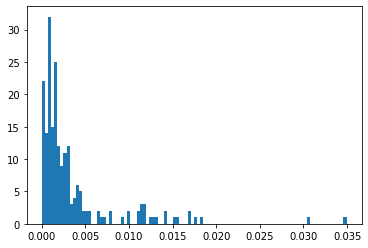

In [11]:
# percentage of 1's in each column of y
one_perc = y.apply(lambda x: x.sum()/len(y))
plt.figure()
plt.hist(one_perc, bins=100);

In [12]:
# categorical columns
col_cat = [col for col in X.columns if X[col].dtype == 'object']
col_cat

['cp_type', 'cp_dose']

In [13]:
X.cp_type.value_counts()

trt_cp         21948
ctl_vehicle     1866
Name: cp_type, dtype: int64

In [14]:
X.cp_dose.value_counts()

D1    12147
D2    11667
Name: cp_dose, dtype: int64

## Preprocessing

In [15]:
# One-hot encoding for cp_type and cp_dose
X['cp_type'].replace({'trt_cp':1., 'ctl_vehicle':0.}, inplace=True)
X['cp_dose'].replace({'D1':1., 'D2':0.}, inplace=True)

In [16]:
# split into training set and test set
ids = X.index.values.copy()
np.random.shuffle(ids)

train_perc, test_perc = 0.8, 0.2
train_id = ids[:round(len(ids)*train_perc)]
test_id = ids[round(len(ids)*train_perc)+1:]

X_train = X.loc[train_id]
X_test = X.loc[test_id]

y_train = y.loc[train_id]
y_test = y.loc[test_id]

In [17]:
# normalize the data
scaler = StandardScaler()
X_train_norm = pd.DataFrame(scaler.fit_transform(X_train))
X_train_norm.columns = X_train.columns
X_train_norm.index = X_train.index

X_test_norm = pd.DataFrame(scaler.transform(X_test))
X_test_norm.columns = X_test.columns
X_test_norm.index = X_test.index

In [18]:
X_train_norm.head()

,cp_type,cp_time,cp_dose,g-0,g-1,g-2,g-3,g-4,g-5,g-6,...,c-90,c-91,c-92,c-93,c-94,c-95,c-96,c-97,c-98,c-99
sig_id,,,,,,,,,,,,,,,,,,,,,
id_eed4f5eb5,-3.451946,-1.236669,0.980918,-0.456171,0.005873,0.427600,-1.182563,-0.524187,-0.299103,0.945605,...,0.375991,0.037446,-0.282627,0.153964,0.308799,1.054493,0.141999,0.306620,0.225334,-0.099044
id_528f47dac,0.289692,0.000195,0.980918,0.450424,-0.319481,-1.396536,-0.005718,-0.247520,3.341033,-0.484051,...,0.721413,0.594174,0.488883,0.341703,0.586436,-0.182267,0.546444,0.400113,0.337062,-0.275528
id_f706afa88,0.289692,0.000195,0.980918,-1.099553,-0.396522,0.778984,0.962121,-1.001836,-0.126575,-0.266299,...,-0.087900,0.444295,0.397154,0.733476,0.023046,-0.501745,0.458904,0.297883,-0.976632,-0.523066
id_1bb6de988,0.289692,-1.236669,0.980918,0.036681,0.470222,-0.214747,-0.247864,-0.645399,0.058925,0.002735,...,0.867269,0.825751,0.473814,0.355106,0.348301,0.526270,0.141260,0.030956,0.190197,0.451120
id_a1c138776,0.289692,-1.236669,0.980918,2.208361,1.993362,-0.351596,2.984833,0.780252,-0.034757,0.413108,...,-0.524355,0.430530,0.463650,0.653685,-0.315908,-0.252784,0.071061,0.000940,0.341108,0.516565


## Models  

### Model 1: Neural Network

In [54]:
params_net = {'input_size': X_train_norm.shape[1],
             'hidden_size': [1024, 512, 256, 128 ,256, 512, 1024],
             'output_size': y_train.shape[1],
             'dropout': 0.01}

params_fit = {'X':X_train_norm,
             'y': y_train,
             'epoch': 10,
             'lr': 5e-6,
             'batch_size':128,
             'L2': 0,
             'pos_weight':50,
             'verbose':True}

net = DenseNet(**params_net)
model = Model(net)
model.fit(**params_fit)

Epoch [1, 0] : loss 1.047469139099121
Epoch [1, 3840] : loss 1.0503969192504883
Epoch [1, 7680] : loss 1.0482181310653687
Epoch [1, 11520] : loss 1.0571616888046265
Epoch [1, 15360] : loss 1.0565568208694458
Epoch [2, 0] : loss 1.0441319942474365
Epoch [2, 3840] : loss 1.046202301979065
Epoch [2, 7680] : loss 1.0408885478973389
Epoch [2, 11520] : loss 1.0427759885787964
Epoch [2, 15360] : loss 1.027367115020752
Epoch [3, 0] : loss 0.9818310737609863
Epoch [3, 3840] : loss 0.9502124786376953
Epoch [3, 7680] : loss 0.8936072587966919
Epoch [3, 11520] : loss 0.8563058972358704
Epoch [3, 15360] : loss 0.8363940119743347
Epoch [4, 0] : loss 0.8102911710739136
Epoch [4, 3840] : loss 0.8154917359352112
Epoch [4, 7680] : loss 0.8098849058151245
Epoch [4, 11520] : loss 0.8210698962211609
Epoch [4, 15360] : loss 0.8198848962783813
Epoch [5, 0] : loss 0.8009716868400574
Epoch [5, 3840] : loss 0.8100683689117432
Epoch [5, 7680] : loss 0.8062267303466797
Epoch [5, 11520] : loss 0.8193537592887878
E

In [71]:
y_train_predict = model.predict(X_train_norm, 0.45)

# print('Accuracy: ')
# print(accuracy_score(y_train, y_train_predict))
print('Precision: ')
print(precision_score(y_train, y_train_predict))
print('Recall: ')
print(recall_score(y_train, y_train_predict))
print('F1: ')
print(f1_score(y_train, y_train_predict))

Precision: 
0.1584953508030431
Recall: 
0.08367422833767199
F1: 
0.10952635934381541


In [72]:
y_test_predict = model.predict(X_test_norm, 0.45)

# print('Accuracy: ')
# print(accuracy_score(y_test, y_test_predict))
print('Precision: ')
print(precision_score(y_test, y_test_predict))
print('Recall: ')
print(recall_score(y_test, y_test_predict))
print('F1: ')
print(f1_score(y_test, y_test_predict))

Precision: 
0.18147951037786056
Recall: 
0.1003531489111242
F1: 
0.1292400985408376


In [73]:
print(y_train.sum().sum())
print(y_train_predict.sum())

13445
7098


In [74]:
print(y_test.sum().sum())
print(y_test_predict.sum())

3398
1879


In [ ]:
# grid search for pos_weight




### Model 2: Random Forest

In [139]:
rfc = RandomForestClassifier(n_estimators = 100,
                             max_depth = 20,
                             class_weight = [{0:1, 1:1}]*y_train.shape[1],
                             random_state=100)
rfc.fit(X_train, y_train)

RandomForestClassifier(bootstrap=True,
            class_weight=[{0: 1, 1: 1}, {0: 1, 1: 1}, {0: 1, 1: 1}, {0: 1, 1: 1}, {0: 1, 1: 1}, {0: 1, 1: 1}, {0: 1, 1: 1}, {0: 1, 1: 1}, {0: 1, 1: 1}, {0: 1, 1: 1}, {0: 1, 1: 1}, {0: 1, 1: 1}, {0: 1, 1: 1}, {0: 1, 1: 1}, {0: 1, 1: 1}, {0: 1, 1: 1}, {0: 1, 1: 1}, {0: 1, 1: 1}, {0: 1, 1: 1}, {0: 1, 1: 1}, {0: 1,...}, {0: 1, 1: 1}, {0: 1, 1: 1}, {0: 1, 1: 1}, {0: 1, 1: 1}, {0: 1, 1: 1}, {0: 1, 1: 1}, {0: 1, 1: 1}],
            criterion='gini', max_depth=20, max_features='auto',
            max_leaf_nodes=None, min_impurity_decrease=0.0,
            min_impurity_split=None, min_samples_leaf=1,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            n_estimators=100, n_jobs=None, oob_score=False,
            random_state=100, verbose=0, warm_start=False)

In [135]:
y_train_predict = rfc.predict(X_train_norm)

# print('Accuracy: ')
# print(accuracy_score(y_train, y_train_predict))
print('Precision: ')
print(precision_score(y_train, y_train_predict))
print('Recall: ')
print(recall_score(y_train, y_train_predict))
print('F1: ')
print(f1_score(y_train, y_train_predict))

Precision: 
1.0
Recall: 
0.005801413164745258
F1: 
0.01153590179693855


In [136]:
y_test_predict = rfc.predict(X_test_norm)

# print('Accuracy: ')
# print(accuracy_score(y_test, y_test_predict))
print('Precision: ')
print(precision_score(y_test, y_test_predict))
print('Recall: ')
print(recall_score(y_test, y_test_predict))
print('F1: ')
print(f1_score(y_test, y_test_predict))

Precision: 
1.0
Recall: 
0.002354326074161271
F1: 
0.004697592483852026


In [140]:
print(y_train.sum().sum())
print(y_train_predict.sum())

13445
78.0


In [138]:
print(y_test.sum().sum())
print(y_test_predict.sum())

3398
8.0


In [123]:
# Grid Search 
parameters = {'n_estimators': [100, 150],
             'max_depth': [10, 20, 30],
             'class_weight': [[{0:1, 1:75}]*y_train.shape[1], [{0:1, 1:85}]*y_train.shape[1]]}

rfc = RandomForestClassifier(random_state=100)
clf = GridSearchCV(rfc, parameters, scoring=make_scorer(f1_score, greater_is_better=True))
clf.fit(X_train, y_train)

ValueError: Class label 1 not present.

In [ ]:
print('# Tuning hyper-parameter for f1')
print()
print('Best parameters set found on validation set:')
print(clf.best_params_)
print()
print('Grid scores on validation set: ')
means = clf.cv_results_['mean_test_socre']
stds = clf.cv_results_['std_test_score']
for mean, std, params in zip(means, stds, clf.cv_results_['params']):
    print("{} ({}) for {}".format(mean, std*2, params))

In [112]:
y_train_predict = clf.predict(X_train_norm)

# print('Accuracy: ')
# print(accuracy_score(y_train, y_train_predict))
print('Precision: ')
print(precision_score(y_train, y_train_predict))
print('Recall: ')
print(recall_score(y_train, y_train_predict))
print('F1: ')
print(f1_score(y_train, y_train_predict))

Precision: 
1.0
Recall: 
0.009222759390107848
F1: 
0.018276954823494736


In [113]:
y_test_predict = clf.predict(X_test_norm)

# print('Accuracy: ')
# print(accuracy_score(y_test, y_test_predict))
print('Precision: ')
print(precision_score(y_test, y_test_predict))
print('Recall: ')
print(recall_score(y_test, y_test_predict))
print('F1: ')
print(f1_score(y_test, y_test_predict))

Precision: 
1.0
Recall: 
0.003531489111241907
F1: 
0.007038123167155425


In [114]:
print(y_train.sum().sum())
print(y_train_predict.sum())

13445
124.0


In [115]:
print(y_test.sum().sum())
print(y_test_predict.sum())

3398
12.0


### Model 3 : Classifier Chains (Random Forest)